In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from opt import generate_exclusion_list, make_group_model

/anaconda2/envs/compgen/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
proc_data = pd.read_pickle('data/exp2_data.pkl')

# exclude! ...
excluded = generate_exclusion_list(proc_data, training_contexts=7, goal_chance=1/4.)
for e in excluded:
    proc_data = proc_data[proc_data.subj != e]
    
proc_data = proc_data[proc_data['In Goal']]

100%|██████████| 148/148 [00:57<00:00,  2.60it/s]


For legibility, the construction of the model predictors is offloaded.
The script below returns a dictionary with 
   * the chosen goals (coded as categorical values of 0:n_goals)
   * the Q values from a 2-parameter Q-learner (estimated with importance sampling)
   * the WM values from a 2-parameter WM model (estimated with importance sampling)
   * goal popularity across all contexts
   * goal popularity across all contexts that share a mapping
   * Win-Stay
   * subject id

In [3]:
model_parameters = make_group_model(proc_data)

100%|██████████| 114/114 [03:29<00:00,  1.84s/it]


For softmax regression, it is useful to mean center each prediction vector and sometimes it is useful to normalize. 

In [4]:
# prep all of the subjects

    
from sklearn.preprocessing import normalize

def mean_center(X):
    return X - np.tile(np.mean(X, axis=1), (X.shape[1], 1)).T

y         = model_parameters['Goal-Choice-Id']

X_ind     = mean_center(model_parameters['Prior-Independent'])
X_joint   = mean_center(model_parameters['Prior-Joint'])
X_ws      = mean_center(model_parameters['Win-Stay'])
X_Q       = mean_center(model_parameters['Q-Values'])
X_wm      = mean_center(model_parameters['WM-Value'])

subj_idx  = model_parameters['Subjects']

# decorrelate predictors
X_gen_pop  = mean_center(normalize(X_ind) + normalize(X_joint)) - normalize(X_Q)
X_gen_diff = mean_center(normalize(X_ind) - normalize(X_joint)) - normalize(X_Q)
X_winst    = mean_center(normalize(X_ws) - normalize(X_Q))
X_wm       = mean_center(normalize(X_wm) - normalize(X_Q))

X_ind      = mean_center(normalize(X_ind) - normalize(X_Q))
X_joint    = mean_center(normalize(X_joint) - normalize(X_Q))

In [5]:
from sklearn.metrics.pairwise import paired_cosine_distances
d = paired_cosine_distances(X_ind, X_Q)
dj =paired_cosine_distances(X_joint, X_Q)

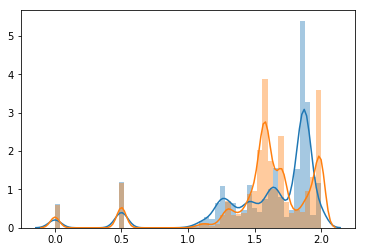

In [6]:
import seaborn as sns
sns.distplot(d)
sns.distplot(dj)

# Models!
Compare the models for model comparison. Samples have already been run.

In [7]:
from theano import tensor as tt
from theano.tensor.nnet.nnet import softmax

N, D = X_ind.shape
n_subj = max(subj_idx) + 1

n_samples = 2000
n_tune = 4000

with pm.Model() as hier_full:
    # here, we write down the model

    # Define heirachical parameters
    # (normal means and standard deviation for regression weights)
    mu_1 = pm.Normal('mu_beta_gen',      mu=0., sd=100.)
    mu_2 = pm.Normal('mu_beta_gen_diff', mu=0., sd=100.)
    mu_3 = pm.Normal('mu_beta_winst',    mu=0., sd=100.)
    mu_4 = pm.Normal('mu_beta_q',        mu=0., sd=100.)
    mu_5 = pm.Normal('mu_beta_wm',       mu=0., sd=100.)

    sigma_1 = pm.HalfCauchy('sigma_gen',       beta=100)
    sigma_2 = pm.HalfCauchy('sigma_gen_didff', beta=100)
    sigma_3 = pm.HalfCauchy('sigma_winst',     beta=100)
    sigma_4 = pm.HalfCauchy('sigma_q',         beta=100)
    sigma_5 = pm.HalfCauchy('sigma_wm',        beta=100)

    # define subject predictor variables (i.e. regression parameters,
    # 1 per subject per condition with a hierachcial prior)
    b_1 = pm.Normal('beta_gen',      mu=mu_1, sd=sigma_1, shape=n_subj)
    b_2 = pm.Normal('beta_gen_diff', mu=mu_2, sd=sigma_2, shape=n_subj)
    b_3 = pm.Normal('beta_winst',    mu=mu_3, sd=sigma_3, shape=n_subj)
    b_4 = pm.Normal('beta_q',        mu=mu_4, sd=sigma_4, shape=n_subj)
    b_5 = pm.Normal('beta_wm',       mu=mu_5, sd=sigma_5, shape=n_subj)

    # linearly combine the predictors with the subject-specific coefficients
    # as a scaling factor. In practice, the coefficients have to be broadcast
    # in to an NxD matric via theano for element-wise multiplication
    rho = \
        tt.tile(tt.reshape(b_1[subj_idx], (N, 1)), D) * X_gen_pop + \
        tt.tile(tt.reshape(b_2[subj_idx], (N, 1)), D) * X_gen_diff + \
        tt.tile(tt.reshape(b_3[subj_idx], (N, 1)), D) * X_winst + \
        tt.tile(tt.reshape(b_4[subj_idx], (N, 1)), D) * X_Q + \
        tt.tile(tt.reshape(b_5[subj_idx], (N, 1)), D) * X_wm
    # note: I think this theano code is slow. Regardless, the more complex
    # the model, the more difficult it will be to estimate.

    # pass the resultant vector through a softmax to convert to a probability
    # distribution. Note, we don't need an additional noise parameter as that
    # would be collinear with the coefficients.
    
    p_hat = softmax(rho)

    # Data likelihood
    yl = pm.Categorical('yl', p=p_hat, observed=y)
    trace_full = pm.sample(n_samples, tune=n_tune, init='advi')


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 15,442:  28%|██▊       | 56191/200000 [11:51<30:20, 78.99it/s]
Convergence archived at 56200
Interrupted at 56,199 [28%]: Average Loss = 17,010
/anaconda2/envs/compgen/lib/python2.7/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_wm, beta_q, beta_winst, beta_gen_diff, beta_gen, sigma_wm_log__, sigma_q_log__, sigma_winst_log__, sigma_gen_didff_log__, sigma_gen_log__, mu_beta_wm, mu_beta_q, mu_beta_winst, mu_beta_gen_diff, mu_beta_gen]
100%|██████████| 6000/6000 [47:28<00:00,  2.11it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [8]:
with pm.Model() as hier_nogen:
    # here, we write down the model

    # Define heirachical parameters
    # (normal means and standard deviation for regression weights)
    mu_3 = pm.Normal('mu_beta_winst',    mu=0., sd=100.)
    mu_4 = pm.Normal('mu_beta_q',        mu=0., sd=100.)
    mu_5 = pm.Normal('mu_beta_wm',       mu=0., sd=100.)

    sigma_3 = pm.HalfCauchy('sigma_winst',     beta=100)
    sigma_4 = pm.HalfCauchy('sigma_q',         beta=100)
    sigma_5 = pm.HalfCauchy('sigma_wm',        beta=100)

    # define subject predictor variables (i.e. regression parameters,
    # 1 per subject per condition with a hierachcial prior)
    b_3 = pm.Normal('beta_winst',    mu=mu_3, sd=sigma_3, shape=n_subj)
    b_4 = pm.Normal('beta_q',        mu=mu_4, sd=sigma_4, shape=n_subj)
    b_5 = pm.Normal('beta_wm',       mu=mu_5, sd=sigma_5, shape=n_subj)

    # linearly combine the predictors with the subject-specific coefficients
    # as a scaling factor. In practice, the coefficients have to be broadcast
    # in to an NxD matric via theano for element-wise multiplication
    rho = \
        tt.tile(tt.reshape(b_3[subj_idx], (N, 1)), D) * X_winst + \
        tt.tile(tt.reshape(b_4[subj_idx], (N, 1)), D) * X_Q + \
        tt.tile(tt.reshape(b_5[subj_idx], (N, 1)), D) * X_wm
    # note: I think this theano code is slow. Regardless, the more complex
    # the model, the more difficult it will be to estimate.

    # pass the resultant vector through a softmax to convert to a probability
    # distribution. Note, we don't need an additional noise parameter as that
    # would be collinear with the coefficients.
    
    p_hat = softmax(rho)

    # Data likelihood
    yl = pm.Categorical('yl', p=p_hat, observed=y)
    trace_nogen = pm.sample(n_samples, tune=n_tune, init='advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 15,403:  26%|██▋       | 52891/200000 [10:22<28:51, 84.97it/s]
Convergence archived at 52900
Interrupted at 52,899 [26%]: Average Loss = 16,862
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_wm, beta_q, beta_winst, sigma_wm_log__, sigma_q_log__, sigma_winst_log__, mu_beta_wm, mu_beta_q, mu_beta_winst]
100%|██████████| 6000/6000 [41:35<00:00,  2.40it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
with pm.Model() as hier_ind:
    # here, we write down the model

    # Define heirachical parameters
    # (normal means and standard deviation for regression weights)
    mu_1 = pm.Normal('mu_beta_ind',      mu=0., sd=100.)
    mu_3 = pm.Normal('mu_beta_winst',    mu=0., sd=100.)
    mu_4 = pm.Normal('mu_beta_q',        mu=0., sd=100.)
    mu_5 = pm.Normal('mu_beta_wm',       mu=0., sd=100.)

    sigma_1 = pm.HalfCauchy('sigma_ind',       beta=100)
    sigma_3 = pm.HalfCauchy('sigma_winst',     beta=100)
    sigma_4 = pm.HalfCauchy('sigma_q',         beta=100)
    sigma_5 = pm.HalfCauchy('sigma_wm',        beta=100)

    # define subject predictor variables (i.e. regression parameters,
    # 1 per subject per condition with a hierachcial prior)
    b_1 = pm.Normal('beta_ind',      mu=mu_1, sd=sigma_1, shape=n_subj)
    b_3 = pm.Normal('beta_winst',    mu=mu_3, sd=sigma_3, shape=n_subj)
    b_4 = pm.Normal('beta_q',        mu=mu_4, sd=sigma_4, shape=n_subj)
    b_5 = pm.Normal('beta_wm',       mu=mu_5, sd=sigma_5, shape=n_subj)

    # linearly combine the predictors with the subject-specific coefficients
    # as a scaling factor. In practice, the coefficients have to be broadcast
    # in to an NxD matric via theano for element-wise multiplication
    rho = \
        tt.tile(tt.reshape(b_1[subj_idx], (N, 1)), D) * X_ind + \
        tt.tile(tt.reshape(b_3[subj_idx], (N, 1)), D) * X_winst + \
        tt.tile(tt.reshape(b_4[subj_idx], (N, 1)), D) * X_Q + \
        tt.tile(tt.reshape(b_5[subj_idx], (N, 1)), D) * X_wm
    # note: I think this theano code is slow. Regardless, the more complex
    # the model, the more difficult it will be to estimate.

    # pass the resultant vector through a softmax to convert to a probability
    # distribution. Note, we don't need an additional noise parameter as that
    # would be collinear with the coefficients.
    
    p_hat = softmax(rho)

    # Data likelihood
    yl = pm.Categorical('yl', p=p_hat, observed=y)
    trace_ind = pm.sample(n_samples, tune=n_tune, init='advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 15,409:  28%|██▊       | 55396/200000 [11:24<29:47, 80.92it/s]
Convergence archived at 55400
Interrupted at 55,399 [27%]: Average Loss = 16,781
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_wm, beta_q, beta_winst, beta_ind, sigma_wm_log__, sigma_q_log__, sigma_winst_log__, sigma_ind_log__, mu_beta_wm, mu_beta_q, mu_beta_winst, mu_beta_ind]
100%|██████████| 6000/6000 [47:14<00:00,  2.12it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [10]:
with pm.Model() as hier_joint:
    # here, we write down the model

    # Define heirachical parameters
    # (normal means and standard deviation for regression weights)
    mu_1 = pm.Normal('mu_beta_joint',    mu=0., sd=100.)
    mu_3 = pm.Normal('mu_beta_winst',    mu=0., sd=100.)
    mu_4 = pm.Normal('mu_beta_q',        mu=0., sd=100.)
    mu_5 = pm.Normal('mu_beta_wm',       mu=0., sd=100.)

    sigma_1 = pm.HalfCauchy('sigma_joint',     beta=100)
    sigma_3 = pm.HalfCauchy('sigma_winst',     beta=100)
    sigma_4 = pm.HalfCauchy('sigma_q',         beta=100)
    sigma_5 = pm.HalfCauchy('sigma_wm',        beta=100)

    # define subject predictor variables (i.e. regression parameters,
    # 1 per subject per condition with a hierachcial prior)
    b_1 = pm.Normal('beta_joint',    mu=mu_1, sd=sigma_1, shape=n_subj)
    b_3 = pm.Normal('beta_winst',    mu=mu_3, sd=sigma_3, shape=n_subj)
    b_4 = pm.Normal('beta_q',        mu=mu_4, sd=sigma_4, shape=n_subj)
    b_5 = pm.Normal('beta_wm',       mu=mu_5, sd=sigma_5, shape=n_subj)

    # linearly combine the predictors with the subject-specific coefficients
    # as a scaling factor. In practice, the coefficients have to be broadcast
    # in to an NxD matric via theano for element-wise multiplication
    rho = \
        tt.tile(tt.reshape(b_1[subj_idx], (N, 1)), D) * X_joint + \
        tt.tile(tt.reshape(b_3[subj_idx], (N, 1)), D) * X_winst + \
        tt.tile(tt.reshape(b_4[subj_idx], (N, 1)), D) * X_Q + \
        tt.tile(tt.reshape(b_5[subj_idx], (N, 1)), D) * X_wm
    # note: I think this theano code is slow. Regardless, the more complex
    # the model, the more difficult it will be to estimate.

    # pass the resultant vector through a softmax to convert to a probability
    # distribution. Note, we don't need an additional noise parameter as that
    # would be collinear with the coefficients.
    
    p_hat = softmax(rho)

    # Data likelihood
    yl = pm.Categorical('yl', p=p_hat, observed=y)
    trace_joint = pm.sample(n_samples, tune=n_tune, init='advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 15,421:  31%|███       | 61092/200000 [12:39<28:47, 80.42it/s]
Convergence archived at 61100
Interrupted at 61,099 [30%]: Average Loss = 16,727
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_wm, beta_q, beta_winst, beta_joint, sigma_wm_log__, sigma_q_log__, sigma_winst_log__, sigma_joint_log__, mu_beta_wm, mu_beta_q, mu_beta_winst, mu_beta_joint]
100%|██████████| 6000/6000 [47:03<00:00,  2.12it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [11]:
df_comp_WAIC = pm.compare((trace_full, trace_ind, trace_joint, trace_nogen),
                          (hier_full, hier_ind, hier_joint, hier_nogen))
df_comp_WAIC.index =  [
    {ii: name for ii, name in enumerate(['Meta', 'Ind', 'Joint', 'Flat'])}[idx] 
    for idx in df_comp_WAIC.index ]

df_comp_WAIC

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Meta,30216.3,293.28,0,0.82,263.03,0,1
Ind,30237.9,253.85,21.61,0.17,263.16,11.61,1
Joint,30280.2,239.9,63.95,0,263.39,17.04,1
Flat,30319.5,197.49,103.19,0.01,263.4,21.4,1


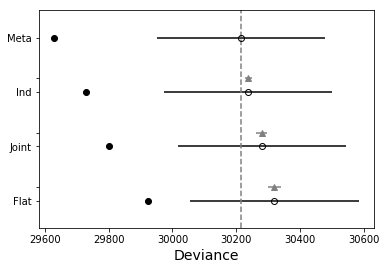

In [12]:
pm.compareplot(df_comp_WAIC)

In [13]:
df_comp_LOO = pm.compare((trace_full, trace_ind, trace_joint, trace_nogen),
                          (hier_full, hier_ind, hier_joint, hier_nogen), ic='LOO')
df_comp_LOO.index =  [
    {ii: name for ii, name in enumerate(['Meta', 'Ind', 'Joint', 'Flat'])}[idx] 
    for idx in df_comp_LOO.index ]

df_comp_LOO

,LOO,pLOO,dLOO,weight,SE,dSE,warning
Meta,30216.9,293.59,0,0.82,263.04,0,1
Ind,30238.6,254.21,21.72,0.17,263.19,11.61,1
Joint,30280.8,240.19,63.9,0,263.41,17.04,1
Flat,30320.2,197.83,103.24,0.01,263.43,21.39,1


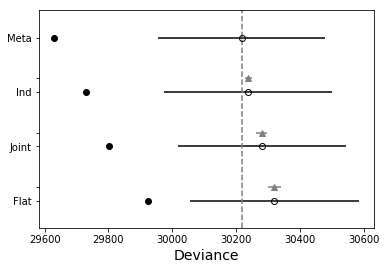

In [17]:
pm.compareplot(df_comp_LOO)
plt.savefig('exp2_ModelComp.png', dpi=300)